Always import libraries

In [2]:
import pandas as pd
import numpy as np
import tools.preprocess_helper as pss
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
#%matplotlib widget
#%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl

In [3]:
df_delft = pd.read_csv('./data/2018/2018_01/'+ 'ADSB_DECODED_20180112.csv.gz',compression= 'gzip')  #'test' + '.csv') # test-1 smaller test dataset
df_open = pd.read_csv('./data/open_sky/January/'+ '2018-01-12.png',compression= 'gzip')  # test-1 smaller test dataset

## Prepare data for next steps

In [4]:
df_delft['onground'] = np.full((df_delft.shape[0]), np.nan)
df_open = pss.opensky_manual(df_open)
df = pd.concat([df_delft, df_open], ignore_index=True)
df = df.drop_duplicates(subset=['ts','icao'])
df = df.drop(df[ (df['alt'] > 10000) | (df['lon'] < 3.3) | (df['lon'] > 5.7) | (df['lat'] < 51.6)
                 | (df['lat'] > 53) | (df['alt'] < -0.1)].index)  # also removes negative altitudes

df = pss.remove_gveh(df)
df = pss.fix_ground(df)

df = df.set_index(['icao', 'ts'])

df = pss.dt_column(df)

## Remove trajectories of less than 1 minute and identify flight phase

In [5]:
df_point = pss.remove_spoint(df, 60.0)  # 60 seconds
df_point = pss.remove_traj(df_point, 60.0, 60.0)  # 60 seconds, might be too short
df_point = pss.divide_flights2(df_point)

## Remove outliers

In [6]:
df_point = df_point.reset_index().set_index('traj')
df_point = pss.remove_outlier(df_point)

## Smooth trajectory and save preprocessed files

In [7]:
new_df = pss.smoother(df_point)
savetxt = new_df.loc[0,'phase'][:8]
#new_df.to_csv("./data/preprocessed/"+savetxt+".csv.gz", compression= 'gzip')

## Check Smoothing results

Pandas doesn't store objects, but only strings. So some manipulation is required when using store data. It doesn't apply if running the full script

In [8]:
# if reading data
smoothed = pd.read_csv('./data/preprocessed/'+ '18-01-12.csv.gz',compression= 'gzip')
original = pd.read_csv('./data/preprocessed/'+ 'test.csv.gz',compression= 'gzip')
# if using computed data, uncomment
#smoothed = new_df
#original = df_point

Set options

In [9]:
choose_parameter = "gs"
example = smoothed.set_index("icao").loc["484F6D"]
print(example.loc[:, "phase"])  # review phases available for this aircraft
phase = 0 # you can change phase 
number_points = example.loc[:, "n_points"][phase]

icao
484F6D    18-01-12-T0
484F6D    18-01-12-L0
484F6D    18-01-12-G2
484F6D    18-01-12-T1
Name: phase, dtype: object


In [28]:
from ast import literal_eval

parameter = example.loc[:, choose_parameter][phase]
parameter = parameter.split('),')
coefficients = np.asarray(literal_eval(parameter[0][7:]))
knots = np.asarray(literal_eval(parameter[1][7:-2]))

# if using computed data
#knots = parameter[1]
#coefficients = parameter[0]

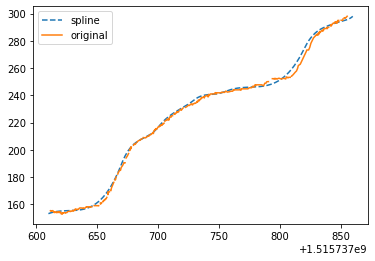

In [29]:
spline = BSpline(knots, coefficients, 3)
t_steps = np.linspace(knots[0], knots[-1], int(number_points))
original = original.reset_index().set_index("icao")
example_original = original.loc["484F6D", :].reset_index().set_index("ts")
example_original = example_original.loc[knots[0] : knots[-1]]
parameter2 = example_original.loc[:, choose_parameter].values


plt.plot(t_steps, spline(t_steps), "--", label = "spline")
plt.plot(example_original.index.values, parameter2, label = "original",)

plt.legend()
plt.show()

## Plot density map

In [ ]:
%matplotlib ipympl
import matplotlib.pyplot as plt
# if using computed data
#df_use = df_point.drop(df_point[(df_point['alt']<-1)|(df_point['alt']>100)].index)
# Reaf from file
df_use = pd.read_csv('./data/preprocessed/'+ 'test.csv.gz',compression= 'gzip')
fig, ax=pss.density_map(df_use)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …